## Prepare the workspace

In [3]:
# Check torch version and CUDA status if GPU is enabled.
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

2.0.1
True


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
from torch import tensor
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import torchvision.models as models
import argparse
from collections import OrderedDict
import json
import PIL
import seaborn as sns
from PIL import Image
import time
import copy

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). 

If you do not find the `flowers/` dataset in the current directory, **/workspace/home/aipnd-project/**, you can download it using the following commands. 

**Method 1**
```bash
!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers
```


**Method 2**
```bash
!cp -r /data/ .
```

## Data Description
The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets

#The transform RandomResizedCrop crops the input image by a random size.
#RandomHorizontalFlip randomly flips the image horizontally with a default probability of 50%.
#CenterCrop crops an 224×224 image from the center.
#Normalize takes in a 3 channel Tensor and normalizes each channel by the input mean and standard deviation for the channel.
#and Each channel in the tensor is normalized as T = (T – mean)/(standard deviation)
#All the above transformations are chained together using Compose.

data_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ])
}
# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}
# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size =64,shuffle = True)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size = 64, shuffle = True)

# Size of Loaders, to be used for calculating Average Loss and Accuracy
train_Loader_size = len(train_loader)
valid_Loader_size = len(validation_loader)
test_loader_size = len(test_loader)

# Print the train, validation and test set data sizes
train_Loader_size, valid_Loader_size, test_loader_size

(103, 13, 13)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. 

## Note for Workspace users: 
If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [8]:
# TODO: Build and train your network

# Load pretrained vgg16 Model
model = models.vgg16(pretrained=True)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 314MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
#to freeze part of the convolutional part of vgg16 model and train the rest
for param in model.parameters():
    param.requires_grad = False
    

In [10]:
#Used OrderedDict to preserve the order in which the keys are inserted
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
            ('inputs', nn.Linear(25088, 120)), #hidden layer 1 sets output to 120
            ('relu1', nn.ReLU()),
            ('dropout',nn.Dropout(0.5)), #could use a different dropout probability, but 0.5 usually works well
            ('hidden_layer1', nn.Linear(120, 90)), #hidden layer 2 output to 90
            ('relu2',nn.ReLU()),
            ('hidden_layer2',nn.Linear(90,70)), #hidden layer 3 output to 70
            ('relu3',nn.ReLU()),
            ('hidden_layer3',nn.Linear(70,102)),#output size = 102
            ('output', nn.LogSoftmax(dim=1))]))# For using NLLLoss()
   
model.classifier = classifier   
# Convert model to be used on GPU
if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [11]:
# Number of steps for gradient descent to take
epochs=15
for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch+1, epochs))


    # Set to training mode
    model.train()

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, (inputs, labels) in enumerate(train_loader):

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        # Clean existing gradients
        optimizer.zero_grad()

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)

        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

        print("Batch no: {:03d}, Loss on training: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

Epoch: 1/15
Batch no: 000, Loss on trainig: 4.6116, Accuracy: 0.0312
Batch no: 001, Loss on trainig: 4.6706, Accuracy: 0.0000
Batch no: 002, Loss on trainig: 4.5605, Accuracy: 0.0156
Batch no: 003, Loss on trainig: 4.6856, Accuracy: 0.0156
Batch no: 004, Loss on trainig: 4.6723, Accuracy: 0.0000
Batch no: 005, Loss on trainig: 4.6168, Accuracy: 0.0156
Batch no: 006, Loss on trainig: 4.6184, Accuracy: 0.0156
Batch no: 007, Loss on trainig: 4.5326, Accuracy: 0.0312
Batch no: 008, Loss on trainig: 4.6919, Accuracy: 0.0469
Batch no: 009, Loss on trainig: 4.6816, Accuracy: 0.0156
Batch no: 010, Loss on trainig: 4.5424, Accuracy: 0.0312
Batch no: 011, Loss on trainig: 4.4579, Accuracy: 0.0781
Batch no: 012, Loss on trainig: 4.4812, Accuracy: 0.0156
Batch no: 013, Loss on trainig: 4.5888, Accuracy: 0.0156
Batch no: 014, Loss on trainig: 4.5845, Accuracy: 0.0469
Batch no: 015, Loss on trainig: 4.5816, Accuracy: 0.0156
Batch no: 016, Loss on trainig: 4.6049, Accuracy: 0.0000
Batch no: 017, Loss

Batch no: 041, Loss on trainig: 2.9320, Accuracy: 0.2656
Batch no: 042, Loss on trainig: 2.5232, Accuracy: 0.4062
Batch no: 043, Loss on trainig: 2.8538, Accuracy: 0.3438
Batch no: 044, Loss on trainig: 2.8378, Accuracy: 0.3125
Batch no: 045, Loss on trainig: 2.8103, Accuracy: 0.2969
Batch no: 046, Loss on trainig: 2.9528, Accuracy: 0.2812
Batch no: 047, Loss on trainig: 3.0361, Accuracy: 0.2031
Batch no: 048, Loss on trainig: 2.3599, Accuracy: 0.4219
Batch no: 049, Loss on trainig: 2.6840, Accuracy: 0.3438
Batch no: 050, Loss on trainig: 2.7619, Accuracy: 0.2656
Batch no: 051, Loss on trainig: 2.8672, Accuracy: 0.3125
Batch no: 052, Loss on trainig: 2.7355, Accuracy: 0.2812
Batch no: 053, Loss on trainig: 2.7165, Accuracy: 0.2812
Batch no: 054, Loss on trainig: 2.4003, Accuracy: 0.3906
Batch no: 055, Loss on trainig: 2.6450, Accuracy: 0.2812
Batch no: 056, Loss on trainig: 2.7903, Accuracy: 0.2188
Batch no: 057, Loss on trainig: 2.5570, Accuracy: 0.2656
Batch no: 058, Loss on trainig:

Batch no: 082, Loss on trainig: 2.2930, Accuracy: 0.4062
Batch no: 083, Loss on trainig: 2.5387, Accuracy: 0.3281
Batch no: 084, Loss on trainig: 2.4296, Accuracy: 0.2969
Batch no: 085, Loss on trainig: 2.1833, Accuracy: 0.4531
Batch no: 086, Loss on trainig: 2.2567, Accuracy: 0.3906
Batch no: 087, Loss on trainig: 2.1964, Accuracy: 0.3906
Batch no: 088, Loss on trainig: 2.6359, Accuracy: 0.3594
Batch no: 089, Loss on trainig: 2.6886, Accuracy: 0.3125
Batch no: 090, Loss on trainig: 1.9128, Accuracy: 0.5000
Batch no: 091, Loss on trainig: 2.4491, Accuracy: 0.3750
Batch no: 092, Loss on trainig: 2.1663, Accuracy: 0.4375
Batch no: 093, Loss on trainig: 2.2354, Accuracy: 0.3594
Batch no: 094, Loss on trainig: 2.4681, Accuracy: 0.3281
Batch no: 095, Loss on trainig: 2.2597, Accuracy: 0.3438
Batch no: 096, Loss on trainig: 2.0252, Accuracy: 0.5156
Batch no: 097, Loss on trainig: 2.2572, Accuracy: 0.3594
Batch no: 098, Loss on trainig: 2.1578, Accuracy: 0.4844
Batch no: 099, Loss on trainig:

Batch no: 020, Loss on trainig: 1.8350, Accuracy: 0.5312
Batch no: 021, Loss on trainig: 1.9679, Accuracy: 0.4688
Batch no: 022, Loss on trainig: 1.9524, Accuracy: 0.4531
Batch no: 023, Loss on trainig: 1.7224, Accuracy: 0.5625
Batch no: 024, Loss on trainig: 2.1721, Accuracy: 0.3125
Batch no: 025, Loss on trainig: 1.7665, Accuracy: 0.5000
Batch no: 026, Loss on trainig: 1.8947, Accuracy: 0.4844
Batch no: 027, Loss on trainig: 1.9961, Accuracy: 0.5156
Batch no: 028, Loss on trainig: 1.6695, Accuracy: 0.5781
Batch no: 029, Loss on trainig: 1.8714, Accuracy: 0.5156
Batch no: 030, Loss on trainig: 2.0876, Accuracy: 0.4219
Batch no: 031, Loss on trainig: 2.0047, Accuracy: 0.4219
Batch no: 032, Loss on trainig: 1.7759, Accuracy: 0.5469
Batch no: 033, Loss on trainig: 1.7923, Accuracy: 0.4688
Batch no: 034, Loss on trainig: 1.6892, Accuracy: 0.4844
Batch no: 035, Loss on trainig: 1.9012, Accuracy: 0.5938
Batch no: 036, Loss on trainig: 1.9696, Accuracy: 0.5000
Batch no: 037, Loss on trainig:

Batch no: 061, Loss on trainig: 1.7325, Accuracy: 0.4844
Batch no: 062, Loss on trainig: 1.7557, Accuracy: 0.5938
Batch no: 063, Loss on trainig: 1.9530, Accuracy: 0.5156
Batch no: 064, Loss on trainig: 1.6530, Accuracy: 0.5469
Batch no: 065, Loss on trainig: 2.0154, Accuracy: 0.5156
Batch no: 066, Loss on trainig: 1.8674, Accuracy: 0.5000
Batch no: 067, Loss on trainig: 1.3919, Accuracy: 0.5781
Batch no: 068, Loss on trainig: 1.5162, Accuracy: 0.6250
Batch no: 069, Loss on trainig: 1.6854, Accuracy: 0.5781
Batch no: 070, Loss on trainig: 1.8868, Accuracy: 0.4062
Batch no: 071, Loss on trainig: 1.7694, Accuracy: 0.5781
Batch no: 072, Loss on trainig: 1.6681, Accuracy: 0.5625
Batch no: 073, Loss on trainig: 1.4140, Accuracy: 0.5625
Batch no: 074, Loss on trainig: 1.8685, Accuracy: 0.5312
Batch no: 075, Loss on trainig: 1.7426, Accuracy: 0.5156
Batch no: 076, Loss on trainig: 2.2407, Accuracy: 0.4688
Batch no: 077, Loss on trainig: 1.5300, Accuracy: 0.5312
Batch no: 078, Loss on trainig:

Batch no: 102, Loss on trainig: 1.9658, Accuracy: 0.4583
Epoch: 8/15
Batch no: 000, Loss on trainig: 1.4422, Accuracy: 0.5625
Batch no: 001, Loss on trainig: 1.5352, Accuracy: 0.5625
Batch no: 002, Loss on trainig: 1.6609, Accuracy: 0.5156
Batch no: 003, Loss on trainig: 1.3277, Accuracy: 0.6094
Batch no: 004, Loss on trainig: 1.5449, Accuracy: 0.5781
Batch no: 005, Loss on trainig: 1.1090, Accuracy: 0.7344
Batch no: 006, Loss on trainig: 1.6971, Accuracy: 0.4688
Batch no: 007, Loss on trainig: 1.7578, Accuracy: 0.4531
Batch no: 008, Loss on trainig: 1.9253, Accuracy: 0.4844
Batch no: 009, Loss on trainig: 1.7230, Accuracy: 0.5312
Batch no: 010, Loss on trainig: 1.7690, Accuracy: 0.5156
Batch no: 011, Loss on trainig: 1.8282, Accuracy: 0.4688
Batch no: 012, Loss on trainig: 1.6093, Accuracy: 0.5312
Batch no: 013, Loss on trainig: 1.8923, Accuracy: 0.4375
Batch no: 014, Loss on trainig: 1.6716, Accuracy: 0.5000
Batch no: 015, Loss on trainig: 1.7960, Accuracy: 0.5312
Batch no: 016, Loss

Batch no: 040, Loss on trainig: 2.1829, Accuracy: 0.4375
Batch no: 041, Loss on trainig: 1.2039, Accuracy: 0.6406
Batch no: 042, Loss on trainig: 1.3098, Accuracy: 0.6875
Batch no: 043, Loss on trainig: 1.5162, Accuracy: 0.6094
Batch no: 044, Loss on trainig: 1.5656, Accuracy: 0.6406
Batch no: 045, Loss on trainig: 1.4919, Accuracy: 0.5469
Batch no: 046, Loss on trainig: 1.6116, Accuracy: 0.5312
Batch no: 047, Loss on trainig: 1.9209, Accuracy: 0.4844
Batch no: 048, Loss on trainig: 1.5027, Accuracy: 0.5156
Batch no: 049, Loss on trainig: 1.6576, Accuracy: 0.5000
Batch no: 050, Loss on trainig: 1.4272, Accuracy: 0.6250
Batch no: 051, Loss on trainig: 1.5398, Accuracy: 0.6406
Batch no: 052, Loss on trainig: 1.6159, Accuracy: 0.5469
Batch no: 053, Loss on trainig: 1.3794, Accuracy: 0.6250
Batch no: 054, Loss on trainig: 1.5516, Accuracy: 0.5938
Batch no: 055, Loss on trainig: 1.4369, Accuracy: 0.6094
Batch no: 056, Loss on trainig: 1.9421, Accuracy: 0.4688
Batch no: 057, Loss on trainig:

Batch no: 081, Loss on trainig: 1.5185, Accuracy: 0.6406
Batch no: 082, Loss on trainig: 1.4412, Accuracy: 0.5938
Batch no: 083, Loss on trainig: 1.1849, Accuracy: 0.6406
Batch no: 084, Loss on trainig: 1.5597, Accuracy: 0.5625
Batch no: 085, Loss on trainig: 1.4689, Accuracy: 0.6406
Batch no: 086, Loss on trainig: 1.3720, Accuracy: 0.6406
Batch no: 087, Loss on trainig: 1.4946, Accuracy: 0.6406
Batch no: 088, Loss on trainig: 1.6003, Accuracy: 0.5625
Batch no: 089, Loss on trainig: 1.3290, Accuracy: 0.6562
Batch no: 090, Loss on trainig: 1.5016, Accuracy: 0.6094
Batch no: 091, Loss on trainig: 1.5599, Accuracy: 0.5781
Batch no: 092, Loss on trainig: 1.5545, Accuracy: 0.5781
Batch no: 093, Loss on trainig: 1.7208, Accuracy: 0.5469
Batch no: 094, Loss on trainig: 1.6744, Accuracy: 0.5625
Batch no: 095, Loss on trainig: 1.8629, Accuracy: 0.4531
Batch no: 096, Loss on trainig: 1.5271, Accuracy: 0.5625
Batch no: 097, Loss on trainig: 1.4151, Accuracy: 0.5156
Batch no: 098, Loss on trainig:

Batch no: 019, Loss on trainig: 1.2444, Accuracy: 0.6250
Batch no: 020, Loss on trainig: 1.0369, Accuracy: 0.7500
Batch no: 021, Loss on trainig: 1.5209, Accuracy: 0.5781
Batch no: 022, Loss on trainig: 1.7457, Accuracy: 0.5312
Batch no: 023, Loss on trainig: 1.2990, Accuracy: 0.5938
Batch no: 024, Loss on trainig: 1.6367, Accuracy: 0.5781
Batch no: 025, Loss on trainig: 1.5771, Accuracy: 0.5469
Batch no: 026, Loss on trainig: 1.1946, Accuracy: 0.6719
Batch no: 027, Loss on trainig: 1.2811, Accuracy: 0.6250
Batch no: 028, Loss on trainig: 1.9869, Accuracy: 0.4375
Batch no: 029, Loss on trainig: 1.5492, Accuracy: 0.5469
Batch no: 030, Loss on trainig: 1.2053, Accuracy: 0.7188
Batch no: 031, Loss on trainig: 1.8079, Accuracy: 0.5156
Batch no: 032, Loss on trainig: 1.2083, Accuracy: 0.7031
Batch no: 033, Loss on trainig: 1.4326, Accuracy: 0.5938
Batch no: 034, Loss on trainig: 1.4791, Accuracy: 0.5781
Batch no: 035, Loss on trainig: 1.8150, Accuracy: 0.4688
Batch no: 036, Loss on trainig:

Batch no: 060, Loss on trainig: 1.1799, Accuracy: 0.6250
Batch no: 061, Loss on trainig: 1.6869, Accuracy: 0.5156
Batch no: 062, Loss on trainig: 1.4786, Accuracy: 0.6250
Batch no: 063, Loss on trainig: 1.4729, Accuracy: 0.5469
Batch no: 064, Loss on trainig: 1.3870, Accuracy: 0.6094
Batch no: 065, Loss on trainig: 1.7318, Accuracy: 0.5156
Batch no: 066, Loss on trainig: 1.2612, Accuracy: 0.5625
Batch no: 067, Loss on trainig: 1.6399, Accuracy: 0.5469
Batch no: 068, Loss on trainig: 1.3542, Accuracy: 0.6094
Batch no: 069, Loss on trainig: 1.3701, Accuracy: 0.6406
Batch no: 070, Loss on trainig: 1.3774, Accuracy: 0.6094
Batch no: 071, Loss on trainig: 1.5149, Accuracy: 0.5625
Batch no: 072, Loss on trainig: 1.6361, Accuracy: 0.5781
Batch no: 073, Loss on trainig: 1.2537, Accuracy: 0.6250
Batch no: 074, Loss on trainig: 1.2077, Accuracy: 0.6094
Batch no: 075, Loss on trainig: 1.0024, Accuracy: 0.7344
Batch no: 076, Loss on trainig: 1.2937, Accuracy: 0.7031
Batch no: 077, Loss on trainig:

Batch no: 101, Loss on trainig: 1.1879, Accuracy: 0.6094
Batch no: 102, Loss on trainig: 1.7685, Accuracy: 0.5417
Epoch: 15/15
Batch no: 000, Loss on trainig: 1.0104, Accuracy: 0.7188
Batch no: 001, Loss on trainig: 1.7125, Accuracy: 0.4844
Batch no: 002, Loss on trainig: 1.2228, Accuracy: 0.6406
Batch no: 003, Loss on trainig: 1.2977, Accuracy: 0.6250
Batch no: 004, Loss on trainig: 1.5830, Accuracy: 0.5312
Batch no: 005, Loss on trainig: 1.2697, Accuracy: 0.5781
Batch no: 006, Loss on trainig: 1.3740, Accuracy: 0.5938
Batch no: 007, Loss on trainig: 1.5207, Accuracy: 0.5781
Batch no: 008, Loss on trainig: 1.4349, Accuracy: 0.5938
Batch no: 009, Loss on trainig: 1.1497, Accuracy: 0.6250
Batch no: 010, Loss on trainig: 1.5395, Accuracy: 0.5938
Batch no: 011, Loss on trainig: 1.5248, Accuracy: 0.5469
Batch no: 012, Loss on trainig: 1.4525, Accuracy: 0.6875
Batch no: 013, Loss on trainig: 1.1235, Accuracy: 0.6875
Batch no: 014, Loss on trainig: 1.3460, Accuracy: 0.6719
Batch no: 015, Los

In [14]:
# Do validation on the test set
correct,total = 0,0
with torch.no_grad():
    model.eval()
    for data in train_loader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy is: %d%%' % (100 * correct / total))
print(model)
print(model.state_dict().keys())

Accuracy is: 80%
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padd

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [15]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
torch.save({'structure' :'alexnet',
            'hidden_layer1':120,
             'dropout':0.5,
             'epochs':19,
             'state_dict':model.state_dict(),
             'class_to_idx':model.class_to_idx,
             'optimizer_dict':optimizer.state_dict()},
             'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

# Using torch.load: Uses pickle’s unpickling facilities to deserialize pickled object files to memory.  
#with the format, torch.load(.., map_location='cpu')
def loading_the_checkpoint(path='checkpoint.pth'):
    #load the saved file
    checkpoint = torch.load('checkpoint.pth')
    #download pretrained model
    model=models.vgg16(pretrained=True)
    #to freeze parameters
    for param in model.parameters():
        param.requires_grad = False
    #load from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    img = PIL.Image.open(image)

    # Get original dimensions
    original_width, original_height = img.size

    # Find shorter size and create settings to crop shortest side to 256
    if original_width < original_height:
        size=[256, 256**600]
    else: 
        size=[256**600, 256]
        
    img.thumbnail(size)
   

    center = original_width/4, original_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    img = img.crop((left, top, right, bottom))

    numpy_img = np.array(img)/255 

    # Normalize each color channel
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    numpy_img = (numpy_img-mean)/std
        
    # Set the color to the first channel
    numpy_img = numpy_img.transpose(2, 0, 1)
    
    return numpy_img

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

<Axes: >

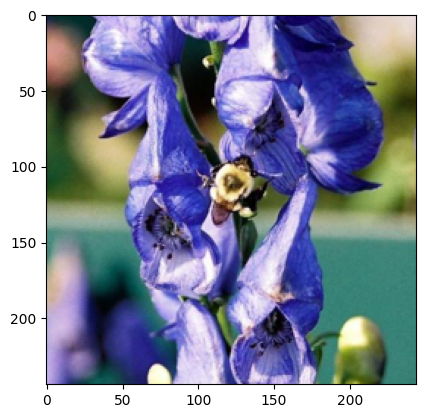

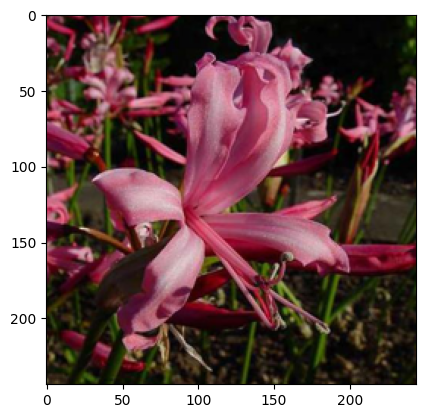

In [19]:
def imshow(image, ax=None, title=None):
    #img for tensor
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))   
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image("flowers/test/9/image_06413.jpg"))
imshow(process_image("flowers/test/37/image_03734.jpg"))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

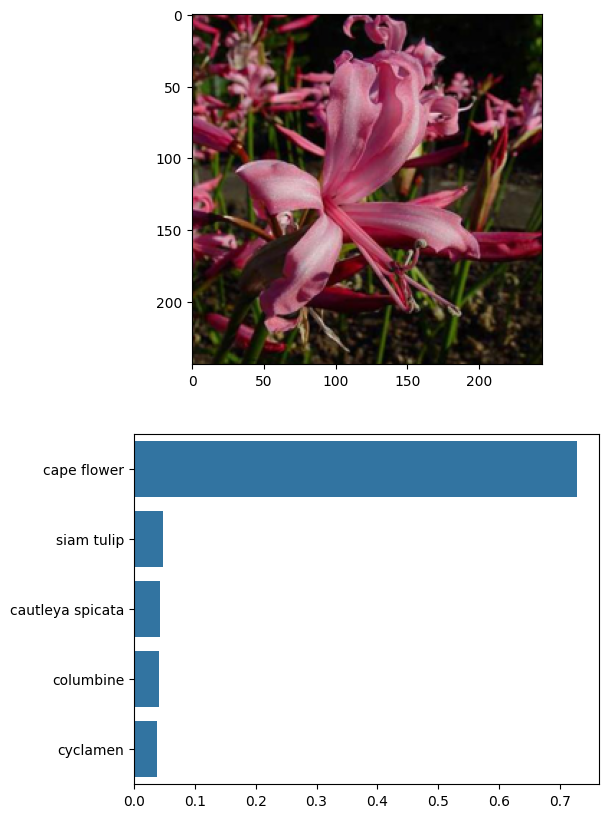

In [23]:
# TODO: Display an image along with the top 5 classes
# Define image path
image_path = "flowers/test/37/image_03734.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show();

## Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace
!rm checkpoint.pth